In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from dreamz.cppn import get_xy_mesh, CPPNNet, UpsampleNet
from torch import optim
from dreamz.render import train_visualiser
from dreamz.torch_layers import Lambda
from torch import nn
from torchvision import datasets, models, transforms

In [3]:
device = 'cuda'

In [4]:
if 1:
    model = models.resnet18(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-4] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
else:
    model = models.vgg11_bn(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-1] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
model = model.eval()

In [5]:
import torch
mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

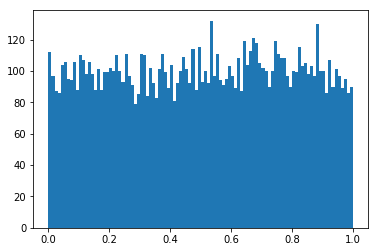

In [6]:
beta = torch.distributions.beta.Beta(torch.tensor([0.0001]), torch.tensor([0.0001]))
beta = torch.distributions.uniform.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
plt.hist(beta.sample([10000]).numpy()[:, 0], bins=100)
plt.show()

In [7]:
widths = [30] * 10
base = CPPNNet(widths, output_channels=widths[-1], input_channels=4)
viz = UpsampleNet(base, reps=1).to(device)

In [8]:
c = 1.0
skip = 5
FEATURE_CHANNEL = 32
# FEATURE_CHANNEL = 43
def imgnet_objective(output, alpha):
    r = model((output - mean) / std)
#     return torch.mean((r - targ) ** 2
#     alpha, beta = alpha
#     loss = (alpha * -r[:, FEATURE_CHANNEL]).mean() + ((1 - alpha) * -r[:, FEATURE_CHANNEL + 2]).mean()
#     loss += (beta * -r[:, FEATURE_CHANNEL + 6]).mean() + ((1 - beta) * -r[:, FEATURE_CHANNEL + 5]).mean()
    
    sel = torch.LongTensor([FEATURE_CHANNEL + i for i in range(0, 4 * skip, skip)])
    loss = -r[:, sel] * ((alpha.unsqueeze(2) * (1-alpha).unsqueeze(1)).view(alpha.shape[0], -1))
    loss = loss.mean()
    
#     loss = -r[:, FEATURE_CHANNEL].mean()
    return loss

size = [59, 105]
xy = get_xy_mesh(size).to(device)
def im_gen_fn(pct_done=0.0, num=16):
    xy_crop = []
    for i in range(num):
        x0 = np.random.randint(0, 105 - 59)
        xy_crop.append(xy[:, :, :, x0:x0 + 59])
    xy_crop = torch.cat(xy_crop, 0)
    r = beta.sample([xy_crop.shape[0], 2])[..., -1].to(device)
    alpha = r.round()  # 16, 2
    other = r * c * 2.0 - 1.0 * c
    other = other.view(xy_crop.shape[0], 2, 1, 1).repeat([1, 1, xy_crop.shape[2], xy_crop.shape[3]])
    xy_crop = torch.cat([xy_crop, other], 1)
    return viz(xy_crop), alpha

In [9]:
opt = optim.Adam(viz.parameters(), lr=0.002)
div = 5

  0%|          | 0/300 [00:00<?, ?it/s]/home/liam/.virtualenvs/py36/lib/python3.6/site-packages/torch/nn/functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


cost -0.04848654568195343


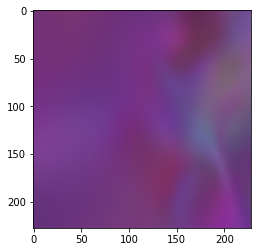

  3%|▎         | 10/300 [00:02<01:12,  4.02it/s]

cost -0.09979836642742157


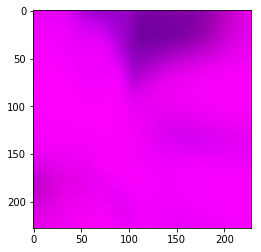

  7%|▋         | 20/300 [00:04<01:08,  4.08it/s]

cost -0.06111694127321243


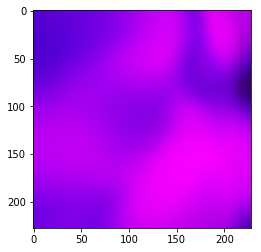

 10%|█         | 30/300 [00:07<01:05,  4.09it/s]

cost -0.07982578873634338


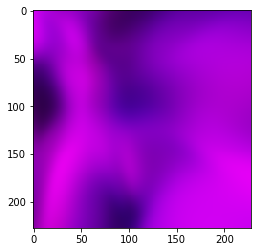

 13%|█▎        | 40/300 [00:10<01:03,  4.08it/s]

cost -0.09144406020641327


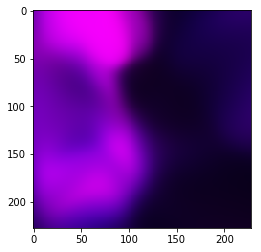

 17%|█▋        | 50/300 [00:12<01:01,  4.06it/s]

cost -0.0905187726020813


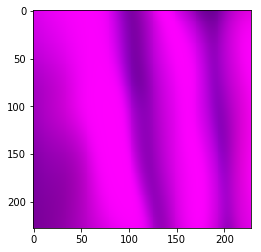

 20%|██        | 60/300 [00:15<00:59,  4.07it/s]

cost -0.09069845080375671


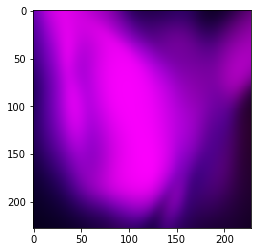

 23%|██▎       | 70/300 [00:17<00:56,  4.06it/s]

cost -0.09152615815401077


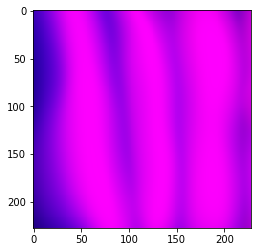

 27%|██▋       | 80/300 [00:20<00:54,  4.07it/s]

cost -0.07202110439538956


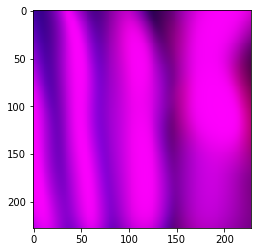

 30%|███       | 90/300 [00:22<00:51,  4.06it/s]

cost -0.051851239055395126


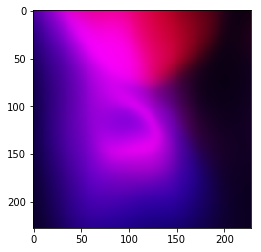

 33%|███▎      | 100/300 [00:25<00:49,  4.05it/s]

cost -0.1175747737288475


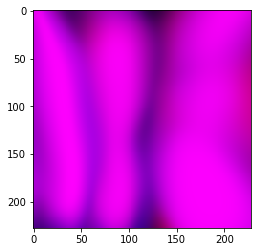

 37%|███▋      | 110/300 [00:28<00:46,  4.04it/s]

cost -0.07230009883642197


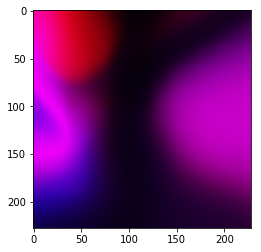

 40%|████      | 120/300 [00:30<00:44,  4.05it/s]

cost -0.004211585968732834


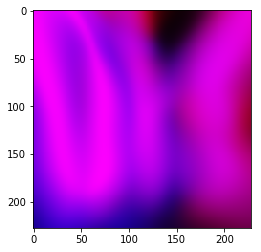

 43%|████▎     | 130/300 [00:33<00:42,  4.05it/s]

cost -0.12147897481918335


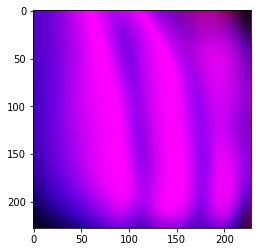

 47%|████▋     | 140/300 [00:35<00:39,  4.04it/s]

cost -0.11740899085998535


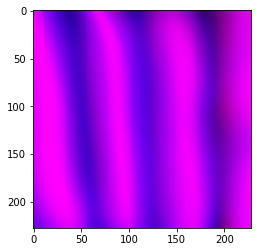

 50%|█████     | 150/300 [00:38<00:37,  4.04it/s]

cost -0.09446259588003159


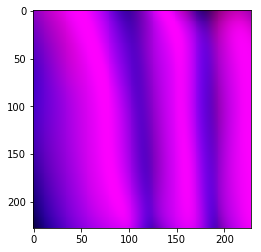

 53%|█████▎    | 160/300 [00:41<00:34,  4.05it/s]

cost -0.007065053563565016


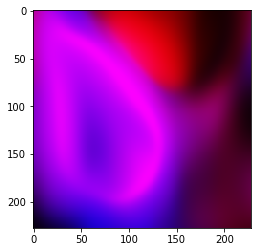

 57%|█████▋    | 170/300 [00:43<00:32,  4.04it/s]

cost -0.1226438507437706


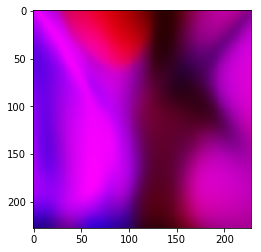

 60%|██████    | 180/300 [00:46<00:29,  4.04it/s]

cost -0.07121331244707108


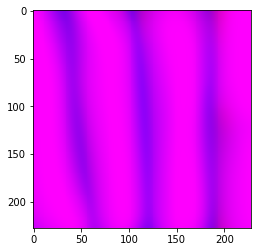

 63%|██████▎   | 190/300 [00:48<00:27,  4.04it/s]

cost -0.1232319250702858


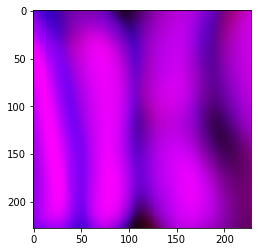

 67%|██████▋   | 200/300 [00:51<00:24,  4.02it/s]

cost -0.07814794778823853


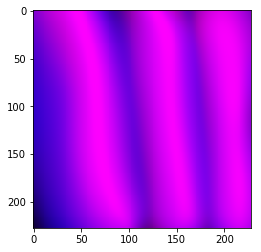

 70%|███████   | 210/300 [00:54<00:22,  4.01it/s]

cost -0.052355606108903885


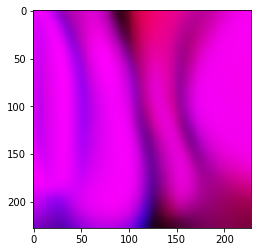

 73%|███████▎  | 220/300 [00:56<00:20,  3.94it/s]

cost -0.07614640146493912


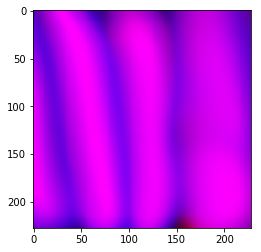

 77%|███████▋  | 230/300 [00:59<00:17,  3.97it/s]

cost -0.08169542253017426


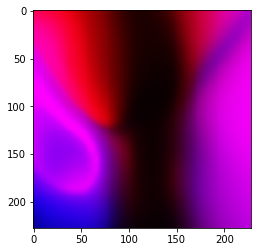

 80%|████████  | 240/300 [01:02<00:15,  3.95it/s]

cost -0.13338547945022583


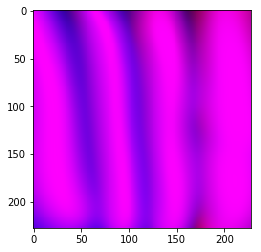

 83%|████████▎ | 250/300 [01:04<00:12,  3.91it/s]

cost -0.1272622048854828


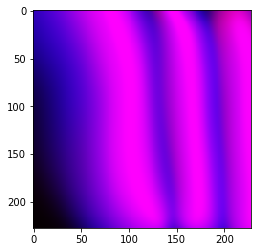

 87%|████████▋ | 260/300 [01:07<00:10,  3.90it/s]

cost -0.19714754819869995


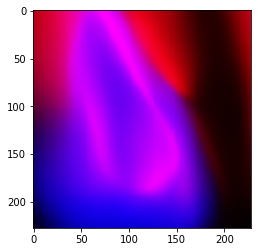

 90%|█████████ | 270/300 [01:10<00:07,  3.96it/s]

cost -0.15069547295570374


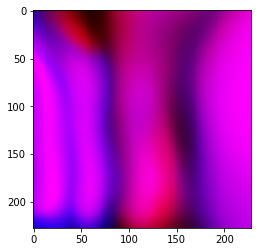

 93%|█████████▎| 280/300 [01:12<00:05,  3.93it/s]

cost -0.03863128274679184


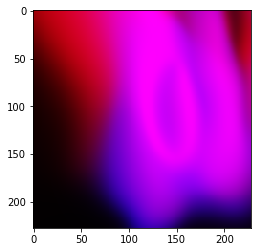

 97%|█████████▋| 290/300 [01:15<00:02,  3.92it/s]

cost -0.08774208277463913


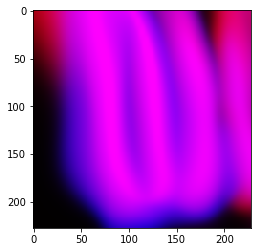

100%|██████████| 300/300 [01:18<00:00,  3.90it/s]


In [10]:
train_visualiser(imgnet_objective, im_gen_fn, opt, iters=30*50//div, log_interval=50//div)

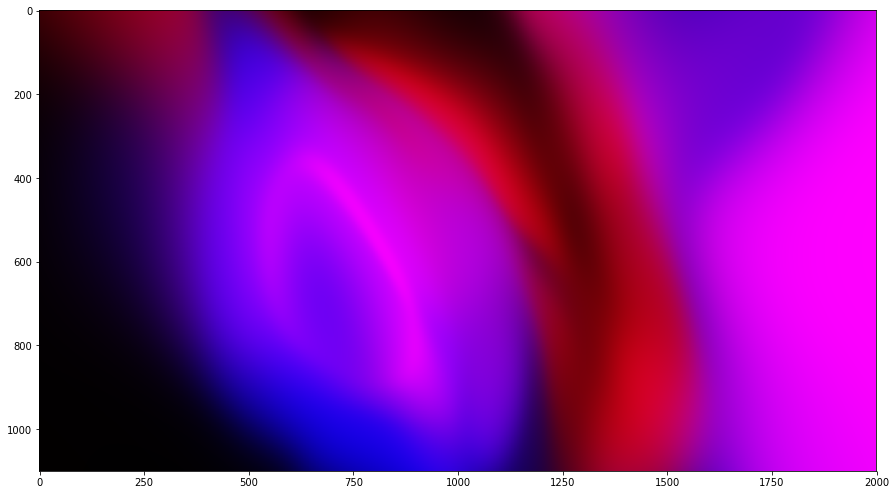

In [11]:
xy_big = get_xy_mesh([277, 502]).to(device)
other = torch.ones([xy_big.shape[0], 2]).to(device) * 2.0 * c - 1.0 * c
other = other.view(xy_big.shape[0], 2, 1, 1).repeat([1, 1, xy_big.shape[2], xy_big.shape[3]])
xy_big = torch.cat([xy_big, other], 1)
res = viz(xy_big)
from dreamz.utils import display_tch_im
plt.figure(figsize=[15]*2)
display_tch_im(res)

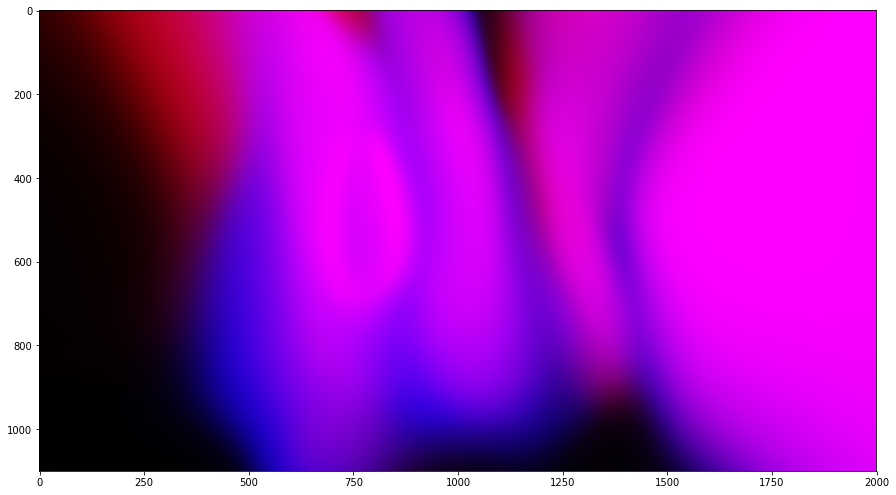

In [12]:
xy_big = get_xy_mesh([277, 502]).to(device)
other = torch.zeros([xy_big.shape[0], 2]).to(device) * 2.0 * c - 1.0 * c
other = other.view(xy_big.shape[0], 2, 1, 1).repeat([1, 1, xy_big.shape[2], xy_big.shape[3]])
xy_big = torch.cat([xy_big, other], 1)
res = viz(xy_big)
from dreamz.utils import display_tch_im
plt.figure(figsize=[15]*2)
display_tch_im(res)

In [13]:
torch.save(viz.state_dict(), '/home/liam/dreamz/data/state_dicts/02.pth')

In [13]:
class Wrapper(nn.Module):
    def __init__(self, m):
        super(Wrapper, self).__init__()
        self.m = m

    def forward(self, x, o):
        o = o.view([1, 2, 1, 1])
        o = o.repeat([x.size(0), 1, x.size(2), x.size(3)])
        x = torch.cat([x, o], 1)
        x = self.m(x)
        x = torch.cat([x, torch.ones([x.size(0), 1, x.size(2), x.size(3)]).to(x.device)], 1)
        return x.permute(0, 3, 2, 1)

x, o = get_xy_mesh([200, 200]), torch.FloatTensor([0.3, 0.4])
[x, o] = [i.to(device) for i in [x, o]]
cppn_trace = torch.jit.trace(Wrapper(viz), (x, o))
torch.jit.save(cppn_trace, '/home/liam/cppns/{}.pth'.format)

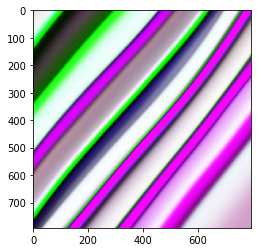

In [14]:
x, o = get_xy_mesh([200, 200]), torch.FloatTensor([-0.3, 0.4])
[x, o] = [i.to(device) for i in [x, o]]
outp = cppn_trace(x, o).to(device)
plt.imshow(outp.detach().cpu().numpy()[0])
plt.show()